# Analyse results

Useful references:
* https://pypsa.readthedocs.io/en/latest/examples/scigrid-lopf-then-pf.html (example from PyPSA documentation with many different visualisations)

## Setup and helpers

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import yaml

# plotting settings
plt.style.use('ggplot') # what is this?
plt.rcParams['figure.figsize'] = (6, 6)
projection = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52) # good for Europe

# Load the network
scenario_name = "full"
file = "base_s_2_elec_175H-Co2L.nc"
network_file = f"../results/{scenario_name}/networks/{file}"
network = pypsa.Network(network_file)

# Load the config file
with open("../config/config.yaml") as stream:
    config = yaml.safe_load(stream)

def plot_europe(fig, ax):
    ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree()) # Europe
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', alpha=0.8)
    ax.add_feature(cfeature.RIVERS, edgecolor='lightblue', alpha=0.8)

    gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels

    return fig, ax

INFO:pypsa.io:Imported network base_s_2_elec_175H-Co2L.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Network map

/Users/jopeel/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


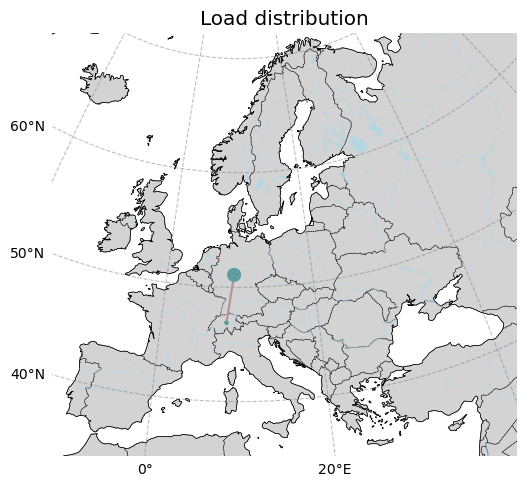

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": projection})

load_distribution = (
    network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)

network.plot(bus_sizes=1e-5 * load_distribution, ax=ax, title="Load distribution")

fig, ax = plot_europe(fig, ax)

## Installed capacities table

In [16]:
network.generators.groupby("carrier")["p_nom"].sum()

carrier
CCGT           3.972848e+04
OCGT           2.331000e+01
PHS            1.257690e+04
biomass        3.337020e+03
coal           3.055187e+04
curtailment    2.000000e+06
hydro          1.080487e+04
lignite        2.305682e+04
load           4.000000e+09
nuclear        2.644800e+04
offwind-ac     0.000000e+00
offwind-dc     0.000000e+00
oil            6.704178e+03
onwind         0.000000e+00
ror            9.439650e+03
solar          0.000000e+00
Name: p_nom, dtype: float64

In [17]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
PHS        12576.896
battery        0.000
hydro      10804.870
Name: p_nom, dtype: float64

## Dispatch plot (WiP)

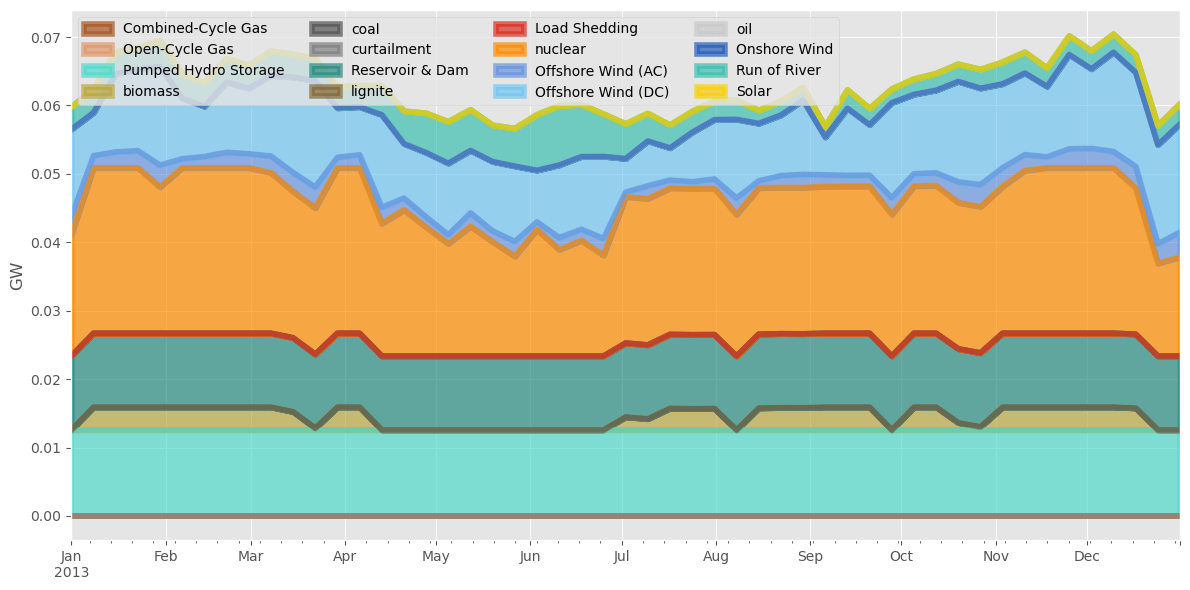

In [26]:
p_by_carrier = network.generators_t.p.T.groupby(network.generators.carrier).sum().T

all_colors = config["plotting"]["tech_colors"]

colors = []
for col in p_by_carrier.columns:
    try:
        colors.append(all_colors[col])
    except KeyError:
        colors.append("gray")

p_by_carrier.rename(columns=config["plotting"]["nice_names"], inplace=True)
p_by_carrier = p_by_carrier / 1e3

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=4, color=colors, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()